In [385]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

def expspace(a0, an, n=50):
    """ linspace in exp space """
    return (a0 * np.exp(np.log(an / a0) * np.linspace(0, 1, n)))


In [264]:
def update_filter(v,p,k):

    dt = p['dt']
    if p['rule'] == 'exp':
        
        # like
        term1 = v['sig2'][k] * v['x'][k] * p['beta']
        
        # spike response kernel alpha = 0 by default
        u = (v['mu'][k].dot(v['x'][k]) - v['alpha'][k]) * p['beta']        
        v['gmap'][k] = p['g0dt'] * np.exp(u)
                
        v['gbar'][k] = v['gmap'][k] * np.exp(v['sig2'][k].dot(v['x'][k]**2)*p['beta']**2 / 2)
        dmu_like = term1 * (v['y'][k] - v['gbar'][k])
        dsig2_like = -v['gbar'][k] * term1**2
        
        # prior for means and covariance
        dmu_pi = -(v['mu'][k] - p['mu_ou']) / p['tau_ou']
        dsig2_pi = np.ones(p['dim']) # init
        ## bias
        if p['include-bias'] == True:
            dmu_pi[0] = -(v['mu'][k, 0] - p['mu_oub']) / p['tau_oub']
                
            ## off-diag terms (inverse addition): (1/tau_b + 1/tau_w approx 1/tau_b)
            dsig2_pi = -(v['sig2'][k] - np.ones(p['dim']) * p['sig2_oub']) / p['tau_oub']

            # bias terms (fast)
            dsig2_pi[0, 0] = 2 * dsig2_pi[0, 0]
            i0 = 1
        else:
            i0 = 0
        
        dsig2_pi[i0:] = -2 * (v['sig2'][k, i0:] - np.ones(p['dim'])*p['sig2_ou']) / p['tau_ou']
    
        # update
        v['mu'][k+1] = v['mu'][k] + dmu_like + dmu_pi*dt
        v['sig2'][k+1] = v['sig2'][k] + dsig2_like + dsig2_pi*dt    

    elif 'exp-oja' == p['rule']:

        # oja factor
        u_oja = v['sig2'][k].dot(v['x'][k])

        # update eigenvector (encoded in sig2)
        dsig2_like = u_oja*(v['x'][k] -  u_oja*v['sig2'][k])/p['tau_z']*p['dt']

        # update eigenvalue1
        dev1 = -(v['ev1'][k] - u_oja**2)/p['tau_z']*p['dt']
        v['ev1'][k+1] = v['ev1'][k] + dev1

        # covariance approx: sigma.dot(x)
        A3 = p['sig2_ou']*p['beta']**2*p['g0dt']/dt*p['tau_ou']*0.5
        vec_dot_x = v['sig2'][k].dot(v['x'][k])
        Sigma_x = p['sig2_ou']*(v['x'][k] - v['ev1'][k]*A3*vec_dot_x*v['sig2'][k])

        v['gmap'][k] = p['g0dt'] * np.exp(
            v['mu'][k].dot(v['x'][k]) * p['beta'])

        v['gbar'][k] = v['gmap'][k] * np.exp(
            v['x'][k].dot(Sigma_x) * p['beta']**2 / 2)

        dmu_like = p['beta']*Sigma_x* (v['y'][k] - v['gbar'][k])                

        # prior for means and covariance
        dmu_pi = -(v['mu'][k] - p['mu_ou']) / p['tau_ou']
        
        ## bias
        if p['include-bias'] == True:
            dmu_pi[0] = -(v['mu'][k, 0] - p['mu_oub']) / p['tau_oub']
    
        # update
        v['mu'][k+1] = v['mu'][k] + dmu_like + dmu_pi*dt
        v['sig2'][k+1] = v['sig2'][k] + dsig2_like        
        
    elif 'exp-rm' == p['rule']:

        dt = p['dt']
        A3 = p['sig2_ou']*p['beta']**2*p['g0dt']/dt*p['tau_ou']/2
        vec_dot_x = v['sig2'][k].dot(v['x'][k])
        Sigma_x = p['sig2_ou']*(v['x'][k] - A3*vec_dot_x*v['sig2'][k])

        v['gmap'][k] = p['g0dt'] * np.exp(
            v['mu'][k].dot(v['x'][k]) * p['beta'])
        v['gbar'][k] = v['gmap'][k] * np.exp(
            v['x'][k].dot(Sigma_x) * p['beta']**2 / 2)
        dmu_like = p['beta'] * (v['y'][k] - v['gbar'][k]) * Sigma_x
        dsig2_like = -(v['sig2'][k] - v['x'][k])/p['tau_z']*p['dt']
        
        # prior for means and covariance
        dmu_pi = -(v['mu'][k] - p['mu_ou']) / p['tau_ou']
        
        ## bias
        if p['include-bias'] == True:
            dmu_pi[0] = -(v['mu'][k, 0] - p['mu_oub']) / p['tau_oub']
    
        # update
        v['mu'][k+1] = v['mu'][k] + dmu_like + dmu_pi*dt
        v['sig2'][k+1] = v['sig2'][k] + dsig2_like
                    
        
    # no cross talk between synapses and bias
    if p['rule'] == 'exp-z': 
            
        # like 
        
        ## beta * z
        term1 = v['sig2'][k] * p['beta']  #OK
        
        # spike response kernel alpha = 0 by default
        u = (v['mu'][k].dot(v['x'][k]) - v['alpha'][k]) * p['beta']        
        v['gmap'][k] = p['g0dt'] * np.exp(u) #OK

        ## x Sig x = z_/0*x_/0 + z_0*1
        v['gbar'][k] = v['gmap'][k] * np.exp(v['sig2'][k].dot(v['x'][k]) * p['beta']**2 / 2)  #OK
        
        dmu_like = term1 * (v['y'][k] - v['gbar'][k]) * v['x'][k] # OK
        dsig2_like = dmu_like.copy() # dummy
        
        if p['include-bias'] == True:        
            dsig2_like[0] = -v['gbar'][k] * term1[0]**2 # OK
            i0 = 1
        else:
            i0 = 0                    
        dsig2_like[i0:] = -v['gbar'][k] * term1[i0:].dot(v['x'][k,i0:]) * term1[i0:] # OK
                
        # prior        
        dmu_pi = -(v['mu'][k] - p['mu_ou']) / p['tau_ou'] # OK        
        
        if p['include-bias'] == True:
            dmu_pi[0] = -(v['mu'][k, 0] - p['mu_oub']) / p['tau_oub'] # OK
                
        ## sig2_ou is diagonal matrix, here scalar
        dsig2_pi = dmu_pi.copy() # dummy

        # bias:
        if p['include-bias'] == True:
            dsig2_pi[0] = - 2 * (v['sig2'][k,0] - p['sig2_oub']) / p['tau_oub']
            i0 = 1
        else: 
            i0 = 0

        ## alpha
        A = p['beta']**2*p['g0dt']/dt*p['tau_ou'] # OK 
        dsig2_pi[i0:] = -2 * (v['sig2'][k,i0:] - p['sig2_ou']*v['x'][k,i0:] 
                         ) / p['tau_ou'] + (p['sig2_ou']*v['xdot'][k,i0:] - 
                         A*v['sig2'][k,i0:].dot(v['xdot'][k,i0:])*v['sig2'][k,i0:]) # OK
                        
        # update
        v['mu'][k+1] = v['mu'][k] + dmu_like + dmu_pi*dt
        v['sig2'][k+1] = v['sig2'][k] + dsig2_like + dsig2_pi*dt
        
        
    elif p['rule'] == 'corr':
    
        # like
        term1 = v['sig2'][k].dot(v['x'][k]) * p['beta']
        
        # spike response kernel alpha = 0 by default
        u = (v['mu'][k].dot(v['x'][k]) - v['alpha'][k]) * p['beta']        
        v['gmap'][k] = p['g0dt'] * np.exp(u)
                
        v['gbar'][k] = v['gmap'][k] * np.exp(v['x'][k].dot(v['sig2'][k].dot(v['x'][k]))*p['beta']**2 / 2)
        dmu_like = term1 * (v['y'][k] - v['gbar'][k])
        dsig2_like = -v['gbar'][k] * term1[np.newaxis,:]*term1[:,np.newaxis]
        
        # prior for means and covariance
        dmu_pi = -(v['mu'][k] - p['mu_ou']) / p['tau_ou']
        dsig2_pi = np.diag(np.ones(p['dim'])) # init
        ## bias
        if p['include-bias'] == True:
            dmu_pi[0] = -(v['mu'][k, 0] - p['mu_oub']) / p['tau_oub']
                
            ## off-diag terms (inverse addition): (1/tau_b + 1/tau_w approx 1/tau_b)
            dsig2_pi = -(v['sig2'][k] - np.diag(np.ones(p['dim']) * p['sig2_oub'])) / p['tau_oub']

            # bias terms (fast)
            dsig2_pi[0, 0] = 2 * dsig2_pi[0, 0]
            i0 = 1
        else:
            i0 = 0
        
        dsig2_pi[i0:, i0:] = -2 * (v['sig2'][k, i0:, i0:] - np.diag(np.ones(p['dim'])*p['sig2_ou'])) / p['tau_ou']
    
        # update
        v['mu'][k+1] = v['mu'][k] + dmu_like + dmu_pi*dt
        v['sig2'][k+1] = v['sig2'][k] + dsig2_like + dsig2_pi*dt

                
def update_protocol(v,p,k):    
    """ call before filter update """
    
    # update world
    dt = p['dt']
    v['x'][k] += v['Sx'][k]  # init cond is zero for entire array            
    v['x'][k + 1] = (1 - dt / p['tau']) * v['x'][k]
    v['xdot'][k] += v['Sx'][k]/dt
    v['xdot'][k+1] = - v['x'][k]*dt/p['tau']
    
    # bias
    if p['include-bias'] == True:
        v['x'][k+1,0], v['x'][k,0] = 1, 1 
        v['xdot'][k+1,0], v['xdot'][k,0] = 0, 0
        
    # spike response kernel:
    if p['include-spike-response-kernel'] == True:    
        #v['alpha'][k] += p['amplitude_alpha']*v['y'][k]  # init cond is zero for entire array
        v['alpha'][k + 1] = (1 - dt / p['tau_alpha']) * v['alpha'][k] + p['amplitude_alpha']*v['y'][k]
    else: 
        v['alpha'][k + 1], v['alpha'][k] = 0, 0
        
        
def update_generator(v,p,k):
    """ call before protocol """
    dt = p['dt']

    # propagate weights
    dW = (dt * p['sig2_ou'] / p['tau_ou'] * 2)**0.5
    v['w'][k+1] = v['w'][k] + dt / p['tau_ou'] * (
                p['mu_ou'] - v['w'][k]) + dW * np.random.randn(p['dim'])    # np.random.randn(p['dim-gm'])
    
    # generate input spikes randomly     
    v['Sx'][k] = np.random.binomial(1,p['rate']*p['dt'],p['dim'])
            
    # generate output spikes
    u = v['w'][k].dot(v['x'][k]) - v['alpha'][k]
    v['g'][k] = p['g0']*np.exp( p['beta']*u)
        
    # catch
    assert not np.isnan(v['g'][k])
    gdt = v['g'][k]*p['dt']
    gdt_gg_one = gdt > 1
    if gdt_gg_one is True:
        gdt = 1
    v['y'][k] = np.random.binomial(1,min(gdt,1))   
    return {'gdt_gg_one':gdt_gg_one}
    

In [265]:
def init(p,mu_0 = None, sig2_0=None,t_num=None):
    v = {}
    dim = p['dim']
    t_num = p['t_num'] if t_num is None else t_num
    
    # other
    v['alpha'] = np.zeros(t_num) # spike response kernel
    v['x'] = np.zeros((t_num, dim))    
    v['Sx'] = np.zeros((t_num, dim))
    v['w'] = np.zeros((t_num, dim))
    v['g'] = np.ones(t_num) * p['g0'] * p['dt']
    v['ev1'] = np.ones(t_num) * 1
    v['u'] = np.zeros(t_num)
    v['gbar'] = np.ones(t_num) * p['g0'] * p['dt']
    v['gmap'] = np.ones(t_num) * p['g0'] * p['dt']  # compute without variance
    v['y'] = np.zeros(t_num)
    v['xdot'] = np.zeros((t_num, dim))
    
    # weights
    v['w'][0] = p['mu_ou'] + np.random.randn(p['dim']) * p['sig2_ou']**0.5
    
    
    # mean
    v['mu'] = np.zeros((t_num, dim))
    if mu_0 is None:
        v['mu'][0] = np.ones(dim) * p['mu_ou']
        
        if p['include-bias'] == True:
            v['mu'][0,0] = p['mu_oub'] # bias
    else:
        v['mu'][0] = mu_0.copy()

    # init sig2
        
    # exp
    if p['rule'] == 'exp':
        v['sig2'] = np.zeros((t_num, dim))
        if sig2_0 is None:
            v['sig2'][0] = np.ones(dim)*p['sig2_ou']
        else:
            v['sig2'][0] = sig2_0.copy()
        
    # corr
    if p['rule'] == 'corr':
        v['sig2'] = np.zeros((t_num, dim, dim))
        if sig2_0 is None:
            v['sig2'][0] = np.diag(np.ones(dim)*p['sig2_ou'])
        else:
            v['sig2'][0] = sig2_0.copy()
        
    # exp-rm and exp-z
    elif (('exp-z' == p['rule']) or ('exp-rm' == p['rule'])):
        v['sig2'] = np.zeros((t_num, dim))
        if sig2_0 is None:
            if p['include-bias'] == True:
                v['sig2'][0,0] = p['mu_oub'] # only bias non-zero
            else:
                v['sig2'][0,0] = 0 #p['mu_ou']
        else:
            v['sig2'][0] = sig2_0.copy()
    
    # oja
    elif 'oja' in p['rule']:
        v['sig2'] = np.zeros((t_num, dim))
        v['ev1'][0] = 1
        if sig2_0 is None:            
            v['sig2'][0,0] = p['sig2_ou']
        else:
            v['sig2'][0] = sig2_0.copy()    
    return v

In [266]:
def init_pre_post_protocol(v,p,wait=0.5):
    
    idx_post = np.array(np.round((wait + np.abs(p['delta_T']))/p['dt']),dtype=int)
    idx_pre = np.array(np.round(wait/p['dt']),dtype=int)
    
    # only first synapse
    if p['include-bias'] == True:
        dim = 1
    else:
        dim = 0
    
    if p['delta_T'] > 0:    
        v['Sx'][idx_pre,dim] = 1
        v['y'][idx_post] = 1
    else:
        v['Sx'][idx_post,dim] = 1
        v['y'][idx_pre] = 1
    return v

In [267]:
def init_correlated_protocol(v,p, wait=0.5):        
    
    # add correlated protocol for all synapses
    idx_spikes = np.array(np.round((wait + np.array(p['correlated_times']))/p['dt']),dtype=int)
    v['Sx'][idx_spikes] = 1
    
    # add STDP protocol
    # wait period for STDP (measured from t=0)
    wait_STDP = 2*wait + p['correlated_times'][-1]        
    init_pre_post_protocol(v,p,wait=wait_STDP)
    
    return v, wait_STDP

In [268]:
def run_timeseries(p, hetero=False):
    # run pre post or correlated protocol, return variable changes

    v = init(p)
    if hetero==False:
        v = init_pre_post_protocol(v,p,wait=p['wait'])
        initial_readout_time = p['wait']
    else: # hetero True
        v, wait_STDP = init_correlated_protocol(v,p,wait=p['wait'])
        initial_readout_time = wait_STDP # after STDP is over
        
    # ensure positivity
    initial_readout_time = max(initial_readout_time,2*p['dt'])
                
    for k in range(p['t_num']-1):
        update_protocol(v,p,k)
        update_filter(v,p,k)
        
    # init and final state
    idx_0 = int(initial_readout_time/p['dt']) - 2
    idx_f = -2
    mu_0, sig2_0 = v['mu'][idx_0], v['sig2'][idx_0]
    mu_f, sig2_f = v['mu'][idx_f], v['sig2'][idx_f]
                    
    return (v, (mu_0, sig2_0, mu_f, sig2_f))

In [269]:
def run_STDP(mp,p, verbose = True, hetero=False):
            
    out = []
    delta_Ts = np.linspace(mp['delta_T_min'],mp['delta_T_max'],mp['num_delta_T'])
    for j,delta_T in enumerate(delta_Ts):
        
        # update pars
        p_cur = p.copy()
        p_cur['delta_T'] = delta_T
        
        # run
        _, (mu_0, sig2_0, mu_f, sig2_f) = run_timeseries(p_cur,hetero=hetero)
        
        # save output
        out.append({'delta_T':delta_T, 
                   'mu_0':mu_0,
                   'sig2_0':sig2_0,
                   'mu_f':mu_f,
                   'sig2_f':sig2_f})

        # progresss
        if verbose == True:
            print(np.ceil(100*j/len(delta_Ts)), end='\r')
        
    return(out)            

In [270]:
def get_performance(v,p,k=0):

    # init
    MSE = np.nan
    #z = np.nan
    #z2 = np.nan
    L = np.nan
    L_pt = np.nan

    # MSE
    delta = v['mu'][k] - v['w'][k] # vec
    MSE = np.mean(delta**2) # num
    
    # moments (not implemented here)
    #vec = delta/v['sig2'][k] # vec
    #z, z2 = np.mean(vec**0.5), np.mean(vec)
    
    # likelihoods    
    # catch instability
    gbar_gg_one = v['gbar'][k] > 1
    if gbar_gg_one is True:
        v['gbar'] = 0.99
        
    gmap_gg_one = v['gmap'][k] > 1
    if gmap_gg_one is True:
        v['gmap'] = 0.99
        
    L, L_pt = [np.log(v[gkey][k] / p['g0dt']) if v['y'][k] > 0 # spike
               else np.log((1 - v[gkey][k]) / (1 - p['g0dt'])) # no spike
               for gkey in ['gbar','gmap']]        

    return {'MSE':MSE, 'L':L, 'L_pt':L_pt, 
            'gbar_gg_one':gbar_gg_one, 
            'gmap_gg_one':gmap_gg_one} 

In [271]:
def shift_vars_back(v,k):
    v['gbar'][k + 1] = v['gbar'][k]
    v['g'][k + 1] = v['g'][k]
    v['y'][k + 1] = v['y'][k]
    v['gmap'][k + 1] = v['gmap'][k]
    for key in v.keys():        
        v[key][0] = v[key][1]


In [439]:
def run_simulation(p, online=True, verbose = False): # 

    # prepare
    out = []        
    t_stop = int(p['tau_ou']//p['dt']*p['epoch_num'])
    t_readout = int(p['tau_ou']*p['epoch_wait']//p['dt'])
    if online:
        t_num = 2
    else:
        p['t_num'] = t_stop + 1
        t_num = p['t_num']

    # run    
    v = init(p,t_num = t_num)
    for t in range(t_stop):
        k = 0 if online else t
        errors = update_generator(v,p,k) # ground truth weights, spikes
        update_protocol(v,p,k)  # compute kernels
        update_filter(v,p,k)
        
        if online is True:
            shift_vars_back(v,k)

        if t >= t_readout:
            res = get_performance(v,p,k=k)
            res.update(errors) # include errors in output
            out.append(res)
    
        if ((verbose is True) and (t % int(p['tau_ou']//p['dt']) == 0)):            
            # progresss
            print(np.ceil(100*t/t_stop), end='\r')            
    
    return pd.DataFrame(out), v

In [431]:
def rainbow(arr):
    """ return an array of colors used for plotting with length arr  """
    if type(arr)==int:
        return(plt.cm.jet(np.linspace(0,1,arr)))
    else:
        return(plt.cm.jet(np.linspace(0,1,len(arr))))

def plt_errorbar(xplt,yplt,yerr,label=None,lw=1,c='k',
                 marker='o',alpha=0.3,ls=None,color=None):
    """ same as plt.errorbar but with shaded area """
    cc = c if color is None else color
    if len(yerr.shape) > 1 and yerr.shape[0] == 2:  # two types of errors
        yerr_l, yerr_h = yerr[0], yerr[1]
    else:
        yerr_l, yerr_h = yerr, yerr
    #plt.plot(xplt, yplt, lw=lw, c=cc, marker=marker, ls=ls, label=label)
    plt.fill_between(xplt, yplt - yerr_l, yplt + yerr_h, color=cc, alpha=alpha)
    
def vplt(v,p,key='mu',dim=None,cut=1,c='k',alpha=1,return_xy=False,err=False):
    
    if key == 'filter' and dim is not None:
        tspan, yplt = vplt(v,p,key='mu',cut=cut,dim=dim,c='red',alpha=alpha,return_xy=True)
        vplt(v,p,key='w',cut=cut,c='k',alpha=alpha,dim=dim)
        # errorbars:
        if err is True:
            yerr = v['sig2'][:-cut,dim] if len(v['sig2'].shape)==2 else v['sig2'][:-cut,dim,dim]
            #if p['rule'] == 'exp-oja':
                
            plt.fill_between(tspan, yplt - yerr, yplt + yerr, color='red', alpha=0.3)
        return 0
        
    if len(v[key].shape) == 2:       
        yplt = v[key][:-cut,dim]
        
    elif len(v[key].shape) == 1:
        yplt = v[key][:-cut]
                
    else: # a matrix, reshape
        yplt = v[key].reshape(len(v[key]),-1)[:-cut,dim]
                
    yplt = yplt.squeeze()            
    tspan = np.arange(len(v[key])-cut)*p['dt']
    
    plt.plot(tspan, yplt ,label=key,lw=1,c=c,alpha=alpha)
        
    plt.ylabel(key)
    plt.xlabel('time [s]')    
    
    if return_xy is True:
        return tspan, yplt

In [432]:
p = {'t_num': 2000,
     'dt': 0.001,
     'dim':2,
     'tau':0.025,
     'g0':1,
     'beta':0.5,
     'mu_ou':0,
     'sig2_ou':1,     
     'tau_ou':1000, # s
     'rule':'corr'}
p['g0dt'] = p['g0']*p['dt']

# STDP
p['delta_T'] = 0.01
p['wait'] = 0.5 # s

# correlation protocol
p['correlated_times'] = np.array([0, 0.01]) # s, two spikes

# bias
p['include-bias'] = False
p['sig2_oub'] = 1
p['tau_oub'] = 0.025
p['mu_oub'] = 1.0
# spike response
p['include-spike-response-kernel'] = True
p['tau_alpha'] = 0.025
p['amplitude_alpha'] = -3/p['beta']
# single vector rules
p['tau_z'] = 1

# performance sims:
p['epoch_num'] = 10
p['epoch_wait'] = 2
p['rate'] = 40 # Hz

Performance simulation 

In [448]:
p['tau_ou'] = 2
p['tau_z'] = 2
p['beta'] = 0.1
p['dim'] = 5
p['dt'] = 0.001
p['rule'] = 'exp-rm'
p['include-spike-response-kernel'] = False
p['include-bias'] = False

out,v = run_simulation(p,verbose=True,online=False)

In [449]:
A = p['sig2_ou']*p['beta']**2*p['g0dt']/p['dt']*p['tau_ou']/2
out.mean()

MSE            0.632169
L              0.000025
L_pt           0.000009
gbar_gg_one    0.000000
gmap_gg_one    0.000000
gdt_gg_one     0.000000
dtype: float64

0

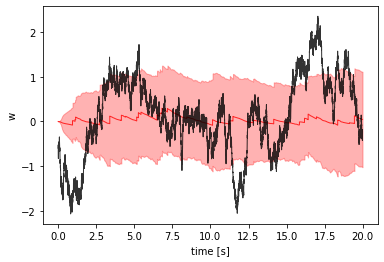

In [450]:
vplt(v,p,key='filter',dim=1,cut=1,c=None,err=True,alpha=0.8)

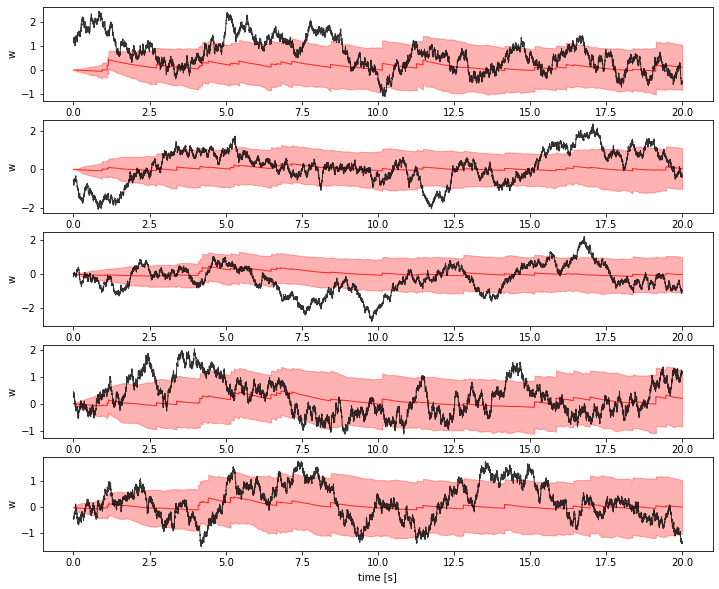

In [451]:
f,axs = plt.subplots(p['dim'],1,figsize=[12,10])
for dim,ax in zip(range(p['dim']),axs.reshape(-1)):
    plt.sca(ax)
    vplt(v,p,key='filter',dim=dim,cut=1,c=None,err=True,alpha=0.8)

In [437]:
import itertools as it

In [438]:
p['tau_ou'] = 2
p['tau_z'] = 2
p['beta'] = 0.1
p['dim'] = 5
p['dt'] = 0.001
p['include-spike-response-kernel'] = False
p['include-bias'] = False

mp = {'betas': expspace(0.001,0.1,5), 'rules': ('exp','corr','exp-oja','exp-rm'), 'repeats': range(10)}
length = len(list(it.product(mp['betas'], mp['rules'], mp['repeats'])))
res = []
for count, (beta, rule, repeat) in enumerate(it.product(mp['betas'], mp['rules'], mp['repeats'])):    
    print(count,'/',length,'rule:',rule,'beta:',beta)
    p['rule'] = rule
    p['beta'] = beta
    out,v = run_simulation(p,verbose=True,online=False)
    out = out.mean().to_dict()
    out.update({'beta':beta,'rule':rule})
    res.append(out)    
res = pd.DataFrame(res)

0 / 200 rule: exp beta: 0.001
1 / 200 rule: exp beta: 0.001
2 / 200 rule: exp beta: 0.001
3 / 200 rule: exp beta: 0.001
4 / 200 rule: exp beta: 0.001
5 / 200 rule: exp beta: 0.001
6 / 200 rule: exp beta: 0.001
7 / 200 rule: exp beta: 0.001
8 / 200 rule: exp beta: 0.001
9 / 200 rule: exp beta: 0.001
10 / 200 rule: corr beta: 0.001
11 / 200 rule: corr beta: 0.001
12 / 200 rule: corr beta: 0.001
13 / 200 rule: corr beta: 0.001
14 / 200 rule: corr beta: 0.001
15 / 200 rule: corr beta: 0.001
16 / 200 rule: corr beta: 0.001
17 / 200 rule: corr beta: 0.001
18 / 200 rule: corr beta: 0.001
19 / 200 rule: corr beta: 0.001
20 / 200 rule: exp-oja beta: 0.001
21 / 200 rule: exp-oja beta: 0.001
22 / 200 rule: exp-oja beta: 0.001
23 / 200 rule: exp-oja beta: 0.001
24 / 200 rule: exp-oja beta: 0.001
25 / 200 rule: exp-oja beta: 0.001
26 / 200 rule: exp-oja beta: 0.001
27 / 200 rule: exp-oja beta: 0.001
28 / 200 rule: exp-oja beta: 0.001
29 / 200 rule: exp-oja beta: 0.001
30 / 200 rule: exp-rm beta: 0.

182 / 200 rule: exp-oja beta: 0.10000000000000005
183 / 200 rule: exp-oja beta: 0.10000000000000005
184 / 200 rule: exp-oja beta: 0.10000000000000005
185 / 200 rule: exp-oja beta: 0.10000000000000005
186 / 200 rule: exp-oja beta: 0.10000000000000005
187 / 200 rule: exp-oja beta: 0.10000000000000005
188 / 200 rule: exp-oja beta: 0.10000000000000005
189 / 200 rule: exp-oja beta: 0.10000000000000005
190 / 200 rule: exp-rm beta: 0.10000000000000005
191 / 200 rule: exp-rm beta: 0.10000000000000005
192 / 200 rule: exp-rm beta: 0.10000000000000005
193 / 200 rule: exp-rm beta: 0.10000000000000005
194 / 200 rule: exp-rm beta: 0.10000000000000005
195 / 200 rule: exp-rm beta: 0.10000000000000005
196 / 200 rule: exp-rm beta: 0.10000000000000005
197 / 200 rule: exp-rm beta: 0.10000000000000005
198 / 200 rule: exp-rm beta: 0.10000000000000005
199 / 200 rule: exp-rm beta: 0.10000000000000005


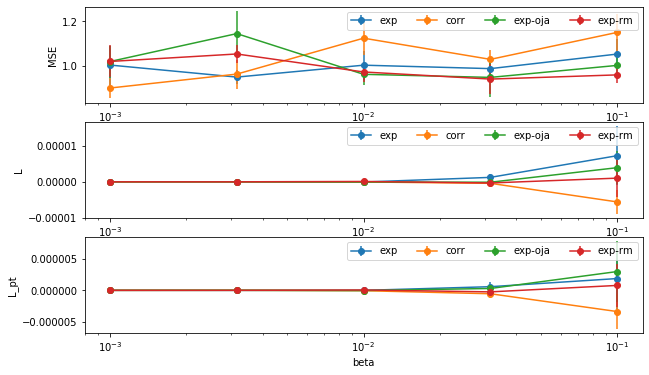

In [443]:
res2 = res.drop(list(res.columns)[3:6],axis=1)
mean = res2.groupby(['rule','beta']).mean()
sem = res2.groupby(['rule','beta']).sem()

f,axs = plt.subplots(3,1,figsize=[10,6])
for metric,ax in zip(('MSE','L','L_pt'),axs.reshape(-1)):
    ax.set_ylabel(metric)
    for rule in mp['rules']:
        mean.loc[rule,metric].plot(label=rule,ax=ax,marker='o',yerr=sem.loc[rule,metric])
    ax.legend(ncol=len(mp['rules']))
    ax.set_xscale('log')

# STDP / Heterosynaptic plasticity 

In [16]:
mp = {'num_delta_T':21,
      'delta_T_max':0.1,
      'delta_T_min':-0.1}

Compare two rules for single time series

In [17]:
test_rule = 'exp-rm'
p['rule'] = test_rule
p['delta_T'] = 0.1
p['dim'] = 1
v, states = run_timeseries(p,hetero=False)

p['rule'] = 'corr'
v2, states = run_timeseries(p,hetero=False)

#p['rule'] = 'corr'
#v2, states = run_timeseries(p,hetero=False)

TypeError: vplt() got an unexpected keyword argument 'c'

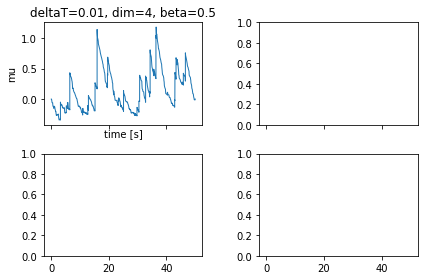

In [189]:
fig, axs = plt.subplots(2,2,tight_layout=True, sharex=True)
plt.sca(axs[0,0])
vplt(v,p,'mu',0) #, plt.xlim([0.45,.55])
plt.title('deltaT={0}, dim={1}, beta={2}'.format(p['delta_T'],p['dim'],p['beta']))
plt.sca(axs[0,1])

vplt(v2,p,'mu',0,c='red') #, plt.xlim([0.45,.55])
plt.title('deltaT={0}, dim={1}, beta={2}'.format(p['delta_T'],p['dim'],p['beta']))

plt.sca(axs[1,0])
vplt(v,p,'sig2',0) #, plt.xlim([0.45,.55])
#plt.title('sig2(t) and z(t)')
plt.ylabel('z(t)')
plt.sca(axs[1,1])
vplt(v2,p,'sig2',0,c='red') #, plt.xlim([0.45,.55])
#plt.title('sig2(t) and z(t)')
#plt.gca().legend(['exp-z','corr'])

Compare STDP protocol for two rules

In [19]:
p['dim'] = 1
p['rule'] = test_rule
out = run_STDP(mp,p)
p['rule'] = 'corr'
out2 = run_STDP(mp,p)

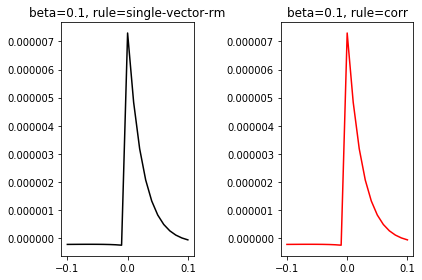

In [20]:
d = 0
def plt_stdp(out,d=0,c='k'):
    xplt, dmu = np.array([(item['delta_T'], item['mu_f'][d] - item['mu_0'][d]) for item in out]).T
    plt.plot(xplt,dmu,c=c)
    plt.title('beta={0}, rule={1}'.format(p['beta'],p['rule']))

fig, axs = plt.subplots(1,2,tight_layout=True)
plt.sca(axs[0])
p['rule'] = test_rule
plt_stdp(out)
p['rule'] = 'corr'
plt.sca(axs[1])
plt_stdp(out2,c='red')
#plt.gca().legend(['exp-z','corr'])

In [21]:
p['rule'] = 'corr' # SF
p['dim'] = 2
v, states = run_timeseries(p,hetero=True)
out = run_STDP(mp,p,hetero=True)

p['rule'] = test_rule
v2, states = run_timeseries(p,hetero=True)
out2 = run_STDP(mp,p,hetero=True)

In [22]:
A = p['beta']**2*(p['g0dt']/p['dt'])*p['tau_ou'] # OK 
A

0.010000000000000002

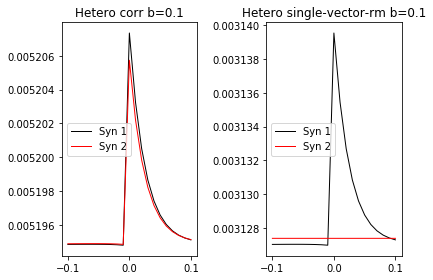

In [23]:
fig, axs = plt.subplots(1,2,tight_layout=True)
for i, out_i, rule in zip([0,1],[out,out2],['corr',test_rule] ):
    plt.sca(axs[i])
    d = 0
    xplt, dmu = np.array([(item['delta_T'], item['mu_f'][d] - item['mu_0'][d]) for item in out_i]).T
    d = 1
    xplt, dmu2 = np.array([(item['delta_T'], item['mu_f'][d] - item['mu_0'][d]) for item in out_i]).T
    plt.plot(xplt,dmu,c='k',lw=1,label='Syn 1')
    plt.plot(xplt,dmu2,c='red',lw=1,label='Syn 2')
    plt.gca().legend()
    plt.title('Hetero {1} b={0}'.format(p['beta'],rule))
